In [1]:

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

array([[ 1.01525117, -0.50026831,  1.        ],
       [ 1.82667184,  0.26139265,  1.        ],
       [ 0.2155647 ,  1.18529436,  0.        ],
       ...,
       [ 0.06124409, -0.04896101,  1.        ],
       [ 1.53389671,  0.33173299,  1.        ],
       [ 1.59228251, -0.53860081,  1.        ]])

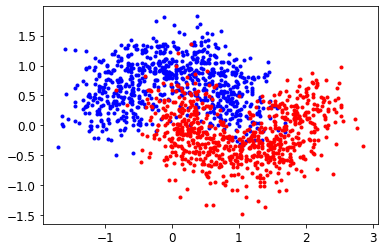

In [371]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

indecies_0 = np.where(y == 0)
indecies_1 = np.where(y == 1)

np.c_[X, y]
#X[:,0:1]
plt.plot(X[indecies_0][:,0:1], X[indecies_0][:,1:], 'b.')
plt.plot(X[indecies_1][:,0:1], X[indecies_1][:,1:], 'r.')

In [372]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
        voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [373]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression()

LogisticRegression 0.8746666666666667


RandomForestClassifier()

RandomForestClassifier 0.9146666666666666


SVC()

SVC 0.9306666666666666


VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

VotingClassifier 0.928


In [374]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [375]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression(random_state=42)

LogisticRegression 0.8746666666666667


RandomForestClassifier(random_state=42)

RandomForestClassifier 0.904


SVC(probability=True, random_state=42)

SVC 0.9306666666666666


VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

VotingClassifier 0.9333333333333333


In [376]:
def yToOutput(y):
    n_classes = y.max() + 1
    m = len(y)
    ny = np.zeros((m, n_classes))
    ny[np.arange(m), y] = 1
    return ny

In [377]:
y_p = yToOutput(y_train)

In [378]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

class MyPolynomialPredictor:
    def __init__(self, degree = 1, start = 0, eta = 0.05, a = 0, epsilon = 1e-7):
        self.theta = np.random.randn(degree + 1, 2)
        self.epsilon = epsilon
        self.a = a
        self.eta = eta
        self.start = start
        self.degree = degree;

    def transform(self, X):
        m = len(X)
        x = np.c_[np.ones((m, 1)), X[:,self.start : self.start + self.degree]]
        return x

    def fit(self, _X, y, n_iterations = 50, Log = True):
        m = len(_X)
        X = self.transform(_X)

        #print(np.zeros([1, self.degree]), self.a * self.theta[1:]])
        #print(np.r_[np.zeros([1, self.degree]), self.a * self.theta[1:]])
        for iteration in range(n_iterations + 1):
            logits = X.dot(self.theta)
            Y_proba = softmax(logits)
            #np.r_[np.zeros([1, self.degree]), self.a * self.theta[1:]]
            loss = -np.mean(np.sum(y * np.log(Y_proba + self.epsilon), axis=1))
            if(Log and iteration % int(n_iterations / 5) == 0):
                print(iteration, loss)
            gradient = 1 / m * X.T.dot(Y_proba - y)  + np.r_[np.zeros([1, 2]), self.a * self.theta[1:]]
            #print(y, gradient)
            self.theta = self.theta - self.eta * gradient
    
    def predict(self, _X):
        X = self.transform(_X)
        return softmax(X.dot(self.theta))


In [379]:
f1 = MyPolynomialPredictor(degree = 2)
f1.fit(X_train, y_p, 1000, Log = True)

y_proba = f1.predict(X_test)
y_predict = np.argmax(y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

0 1.265266742190978
200 0.38381914458597394
400 0.34776323011536897
600 0.33569332042485756
800 0.33056006566675344
1000 0.3281172316385736


0.872

lets see if we can combine all my predictors and create a better one using soft-hard methods

In [380]:
class MyEnsemble:
    def __init__(self, list_models, type = "hard"):
        if(type.lower() == "soft"):
            self.type = 1
        elif(type.lower() == "mean"):
            self.type = 2
        else:
            self.type = 0
        self.models = list_models

    def fit(self, X, y, iterations = 50, log = False):
        for model in self.models:
            model[1].fit(X, y, iterations, log)

    def predict(self, X):
        if(self.type == 1):
            y = self.models[0][1].predict(X)
            for i in range(1, len(self.models)):
                y = np.maximum(y, self.models[i][1].predict(X))
            return y
        if(self.type == 0):
            y = np.round(self.models[0][1].predict(X))
            for i in range(1, len(self.models)):
                y += np.round(self.models[i][1].predict(X))
            return y / len(self.models)
        if(self.type == 2):
            y = self.models[0][1].predict(X)
            for i in range(1, len(self.models)):
                y += self.models[i][1].predict(X)
            return y / len(self.models)

    def accuracy(self, X, y):
        y_predict = np.argmax(self.predict(X), axis=1)
        return np.mean(y_predict == y)


In [395]:
f1 = MyPolynomialPredictor(degree = 2)
f2 = MyPolynomialPredictor(degree = 1)
f3 = MyPolynomialPredictor(degree = 1, start = 1)

ensembler = MyEnsemble([("f2", f2), ("f3", f3)], type = "soft")
ensembler.type

ensembler.fit(X_train, y_p, 1000, log = False)
#np.c_[f1.predict(X_test), f2.predict(X_test)]
#w = np.round(ensembler.predict(X_train))
#w
#ensembler.predict(X_train)

for model in ensembler.models:
    y_pred = np.argmax(model[1].predict(X_test), axis=1)
    print(model[0], np.mean(y_pred == y_test))
print("ensembler", ensembler.accuracy(X_test, y_test))

f4 = MyPolynomialPredictor(degree = 2)
f4.fit(X_train, y_p, 1000, Log=False)
np.mean(np.argmax(f4.predict(X_test), axis=1) == y_test)


1

f2 0.6666666666666666
f3 0.816
f1 0.8746666666666667
ensembler 0.872


0.8746666666666667